# Assumptions

For an actual project I would have talked to people or done further research to remove all of these.

 - GPS logging device stays with the driver, not with the truck. The driver may walk around with the device during a delivery.
 - Data is complete and not a sample
 - As the columns don't exist (but are clearly named to leave space for the missing ones) we only have point to point deliveries with all back hauls excluded.
 - Truck arrival time is considered "delivery time", rather than when the truck had been unloaded and is leaving.
 - Trucks that are "close" to the delivery site are delivering (1km was chosen to be "close").
 - The speed limit is 100kmph
 - Trucks take at least 15 minutes to deliver their cargo
 - As PROJECT_ID has not been described in the accompanying document, I assumed it shouldn't be in the data and its use has been ommited.
 - For the sake of brevity, I've pretended that concept drift doesn't exist and have validated on a random samples of the data. Though I'm happy to discuss how I'd fix this.
 - Trucks may be driven for up to 8 hours a day

# Additional work

It's possible to spend a very significant amount more time on this project. Here are some things that should be explored further for this project:

 - As I used the project in part to learn Polars, there's certainly parts of the code that I think can be improved since finishing.
 - Choosing constants based on analysis, rather than what I decided is probably fine
 - Add documentation to functions describing what they do.
 - Add unit tests to ensure everything works correctly and stays that way
 - Further data cleaning. I'm certain I didn't get every issue.
 - Visualising GPS points on a map and manually inspecting routes that seem odd. Adapting the delivery time detection to be more accurate from this. The implementation I made was very quick and dirty.
 - Accounting for concept drift. For best results this would go hand in hand with seasonality and would require more data. Especially going over December.
 - Hyperparameter tuning of the model
 - As we are supposed to predict the likelihood, checking probability curves and calibrating on additional hold out data may be necessary (though we may not have sufficient data if it's a bit out).

Additional data is also likely to be available (for example the number of satalites used in each GPS point) which can be used to increase the accuracy of the delivery time.

Adding in information about the road network (specifically traffic and distance measurements) are sure to improve the accuracy of the project.

# Deployment plan

There are different ways of deploying a Data Science model. They very much depend on what it will be used for, which is context that is missing from the assignment. It could be as a query-able micro service. It could be coded into a larger program that doesn't want to take a high performance hit from a network request. But probably the most common way is creating a docker container which is scheduled to run (via AirFlow or similar) that takes the data it needs from the relavent databases retrains as neccesary and sends a batch of predictions to another database to be consumed by other programs.

Regardless of choice, monitoring should also be set up to ensure that the inputs and outputs look reasonable, according to some simple rules

In [205]:
import matplotlib.pyplot as plt
import polars as pl
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, cv, Pool

In [2]:
def haversine(theta):
    return np.sin(theta / 2)**2

def polar_distance(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = np.radians(lat1), np.radians(lon1), np.radians(lat2), np.radians(lon2)
    EARTH_RADIUS_KM = 6371
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    return 2*EARTH_RADIUS_KM * np.arcsin(np.sqrt(haversine(dlat) 
                                         + (1 - haversine(dlat) - haversine(lat2 + lat1)) * haversine(dlon)))

# Sense check (should be 455.9km):
polar_distance(51.895568310699595, -5.288800979343314, 51.973689316350054, 1.3624414532350697)

455.9220559497695

In [3]:
bookings = pl.read_csv("Shipment_bookings.csv", try_parse_dates=True)
gps = pl.read_csv("GPS_data.csv", try_parse_dates=True)
to_predict = pl.read_csv("New_bookings.csv", try_parse_dates=True)

In [4]:
gps = gps.sort(["SHIPMENT_NUMBER", "RECORD_TIMESTAMP"]).with_columns(pl.col("RECORD_TIMESTAMP").shift().over("SHIPMENT_NUMBER").alias("prev_TIMESTAMP"))
gps = gps.with_columns((pl.col("RECORD_TIMESTAMP") - pl.col("prev_TIMESTAMP")).alias("time_diff"))
gps = gps.with_columns(pl.col("LAT").shift().over("SHIPMENT_NUMBER").alias("prev_LAT"))
gps = gps.with_columns(pl.col("LON").shift().over("SHIPMENT_NUMBER").alias("prev_LON"))

gps_distances = polar_distance(gps.select("LAT"), gps.select("LON"), gps.select("prev_LAT"), gps.select("prev_LON"))
gps = gps.with_columns(pl.Series(name="distance_since_prev", values=gps_distances.ravel()))

In [5]:
def nano_to_hours(nanos):
    return nanos / (10**9 * 60 * 60)

In [6]:
gps = gps.with_columns((pl.col("distance_since_prev") / nano_to_hours(pl.col("time_diff").dt.total_nanoseconds())).alias("speed_kmph"))

In [7]:
gps_filtered = gps.filter((pl.col("speed_kmph") < 100) & (pl.col("speed_kmph") > 0))

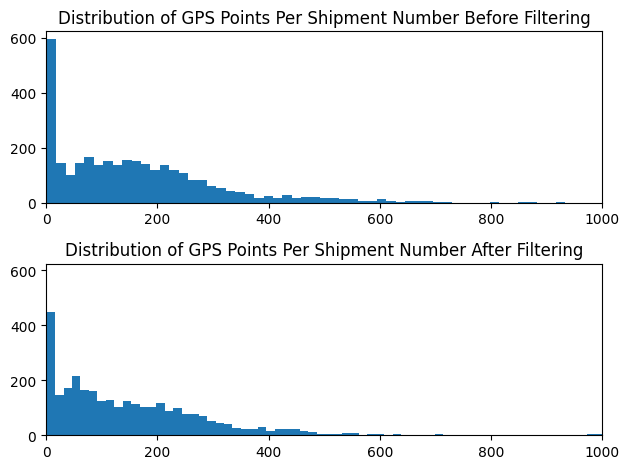

In [8]:
counts = gps.group_by("SHIPMENT_NUMBER").agg(pl.col("LAT").count().alias("gps_points_before")).select("gps_points_before").to_numpy()
filtered_counts = gps_filtered.group_by("SHIPMENT_NUMBER").agg(pl.col("LAT").count().alias("gps_points_after")).select("gps_points_after").to_numpy()

fig, ax = plt.subplots(2, 1, sharey=True, tight_layout=True)

ax[0].set_title("Distribution of GPS Points Per Shipment Number Before Filtering")
ax[0].set_xlim(0, 1000)
ax[0].hist(counts, bins=250)

ax[1].set_title("Distribution of GPS Points Per Shipment Number After Filtering")
ax[1].set_xlim(0, 1000)
ax[1].hist(filtered_counts, bins=250)

plt.show()

In [9]:
MIN_GPS_POINTS = 50
print("Valid shipment numbers before filtering:", len(counts[counts > MIN_GPS_POINTS]))
print("Valid shipment numbers after filtering:", len(filtered_counts[filtered_counts > MIN_GPS_POINTS]))

Valid shipment numbers before filtering: 2412
Valid shipment numbers after filtering: 2263


In [10]:
used_shipment_numbers = gps_filtered.group_by("SHIPMENT_NUMBER").agg(pl.col("LAT").count().alias("gps_points_after"))\
                                   .filter(pl.col("gps_points_after") > MIN_GPS_POINTS).select("SHIPMENT_NUMBER")

In [11]:
used_shipment_numbers

SHIPMENT_NUMBER
str
"""SEZHUK-231115-263028"""
"""SEZHUK-231004-249979"""
"""SEZHUK-231212-272807"""
"""SEZHUK-231001-249105"""
"""SEZHUK-231010-251584"""
…
"""SEZHUK-231210-271974"""
"""SEZHUK-231116-263654"""
"""SEZHUK-231002-249406"""


In [12]:
gps = used_shipment_numbers.join(gps_filtered, on="SHIPMENT_NUMBER").select(["SHIPMENT_NUMBER", "LAT", "LON", "RECORD_TIMESTAMP", "time_diff", "speed_kmph"])

In [13]:
# Check if shipment numbers are unique in bookings
bookings.group_by("SHIPMENT_NUMBER").agg(pl.col("SHIPMENT_NUMBER").count().alias("count")).select("count").max()

count
u32
1


In [14]:
distance_data = gps.join(bookings, on="SHIPMENT_NUMBER").select(["SHIPMENT_NUMBER", "LAT", "LON", "RECORD_TIMESTAMP", "LAST_DELIVERY_LATITUDE", "LAST_DELIVERY_LONGITUDE", "LAST_DELIVERY_SCHEDULE_LATEST"])

In [15]:
distances = polar_distance(distance_data.select("LAT"), distance_data.select("LON"), distance_data.select("LAST_DELIVERY_LATITUDE"), distance_data.select("LAST_DELIVERY_LONGITUDE"))

In [16]:
distance_data = distance_data.with_columns(pl.Series(name="distance_to_delivery", values=distances.ravel()))

In [17]:
close_points = distance_data.filter(pl.col("distance_to_delivery") < 1)

In [18]:
close_points.shape

(24672, 8)

In [19]:
close_points.filter(pl.col("SHIPMENT_NUMBER") == "SEZHUK-231017-253685")

SHIPMENT_NUMBER,LAT,LON,RECORD_TIMESTAMP,LAST_DELIVERY_LATITUDE,LAST_DELIVERY_LONGITUDE,LAST_DELIVERY_SCHEDULE_LATEST,distance_to_delivery
str,f64,f64,"datetime[μs, UTC]",f64,f64,"datetime[μs, UTC]",f64
"""SEZHUK-231017-253685""",52.581813,-1.561633,2023-10-19 18:24:00 UTC,52.583936,-1.557171,2023-10-19 18:25:00 UTC,0.38289
"""SEZHUK-231017-253685""",52.585494,-1.55544,2023-10-19 18:25:00 UTC,52.583936,-1.557171,2023-10-19 18:25:00 UTC,0.209068
"""SEZHUK-231017-253685""",52.586192,-1.555908,2023-10-19 18:26:00 UTC,52.583936,-1.557171,2023-10-19 18:25:00 UTC,0.264984
"""SEZHUK-231017-253685""",52.584631,-1.557371,2023-10-19 18:29:00 UTC,52.583936,-1.557171,2023-10-19 18:25:00 UTC,0.078488


In [20]:
arrivals = close_points.group_by("SHIPMENT_NUMBER").agg(pl.col("RECORD_TIMESTAMP").min().alias("arrival")).join(bookings, on="SHIPMENT_NUMBER").select(["SHIPMENT_NUMBER", "arrival", "LAST_DELIVERY_SCHEDULE_LATEST"])

In [21]:
arrivals = arrivals.with_columns((pl.col("LAST_DELIVERY_SCHEDULE_LATEST") < pl.col("arrival")).alias("is_late"))

In [22]:
arrivals.filter(pl.col("SHIPMENT_NUMBER") == "SEZHUK-231017-253685")

SHIPMENT_NUMBER,arrival,LAST_DELIVERY_SCHEDULE_LATEST,is_late
str,"datetime[μs, UTC]","datetime[μs, UTC]",bool
"""SEZHUK-231017-253685""",2023-10-19 18:24:00 UTC,2023-10-19 18:25:00 UTC,false


In [23]:
arrivals.select("is_late").sum()

is_late
u32
428


In [24]:
arrivals.select("is_late").count() - arrivals.select("is_late").sum()

is_late
u32
1325


In [25]:
arrivals.select("is_late").count()

is_late
u32
1753


In [26]:
len(used_shipment_numbers)

2263

## Journeys with too few GPS points

In [27]:
insufficient_points = len(bookings) - len(used_shipment_numbers)
insufficient_points

982

## Journeys that don't come within 1km of the location

In [28]:
never_arrived = len(used_shipment_numbers) - len(arrivals)
never_arrived

510

## Late deliveries

In [29]:
late = arrivals.select("is_late").sum().to_numpy()[0][0]
late

428

## On time deliveries

In [30]:
on_time = arrivals.select(1-pl.col("is_late")).sum().to_numpy()[0][0]
on_time

1325

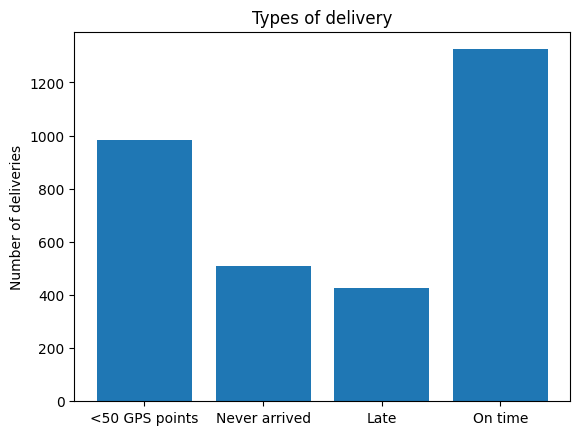

In [31]:
counts = gps.group_by("SHIPMENT_NUMBER").agg(pl.col("LAT").count().alias("gps_points_before")).select("gps_points_before").to_numpy()
filtered_counts = gps_filtered.group_by("SHIPMENT_NUMBER").agg(pl.col("LAT").count().alias("gps_points_after")).select("gps_points_after").to_numpy()

fig, ax = plt.subplots(1, 1)

ax.set_title("Types of delivery")
ax.bar(["<50 GPS points", "Never arrived", "Late", "On time"], [insufficient_points, never_arrived, late, on_time])
ax.set_ylabel("Number of deliveries")

plt.show()

# Feature exploration

In [32]:
bookings.describe()

statistic,PROJECT_ID,SHIPMENT_NUMBER,CARRIER_DISPLAY_ID,VEHICLE_SIZE,VEHICLE_BUILD_UP,FIRST_COLLECTION_POST_CODE,LAST_DELIVERY_POST_CODE,FIRST_COLLECTION_LATITUDE,FIRST_COLLECTION_LONGITUDE,LAST_DELIVERY_LATITUDE,LAST_DELIVERY_LONGITUDE,FIRST_COLLECTION_SCHEDULE_EARLIEST,FIRST_COLLECTION_SCHEDULE_LATEST,LAST_DELIVERY_SCHEDULE_EARLIEST,LAST_DELIVERY_SCHEDULE_LATEST
str,str,str,str,str,str,str,str,f64,f64,f64,f64,str,str,str,str
"""count""","""3245""","""3245""","""3245""","""3245""","""3245""","""3244""","""3241""",3245.0,3245.0,3245.0,3245.0,"""3245""","""3245""","""3245""","""3245"""
"""null_count""","""0""","""0""","""0""","""0""","""0""","""1""","""4""",0.0,0.0,0.0,0.0,"""0""","""0""","""0""","""0"""
"""mean""",null,null,null,null,null,null,null,53.000865,-1.580741,52.465814,-1.511369,"""2023-11-18 16:32:19.085978+00:…","""2023-11-18 19:10:45.564253+00:…","""2023-11-19 06:36:37.944530+00:…","""2023-11-19 07:58:31.620647+00:…"
"""std""",null,null,null,null,null,null,null,0.854579,0.879112,1.09982,1.572145,null,null,null,null
"""min""","""09585ac3-30ad-4115-b56c-878a25…","""SEZHUK-230918-245388""","""CAUK000012""","""18T Rigid""","""20ft Container""","""AL10 8XF""","""AB10 7AY""",50.38645,-6.104285,50.228709,-8.687242,"""2023-09-29 14:00:00+00:00""","""2023-10-01 01:00:00+00:00""","""2023-10-01 03:00:00+00:00""","""2023-10-01 03:30:00+00:00"""
"""25%""",null,null,null,null,null,null,null,52.322608,-2.12066,51.558555,-1.983264,"""2023-10-27 10:00:00+00:00""","""2023-10-27 10:30:00+00:00""","""2023-10-27 16:30:00+00:00""","""2023-10-27 17:00:00+00:00"""
"""50%""",null,null,null,null,null,null,null,53.304842,-1.630808,52.371656,-1.231993,"""2023-11-20 22:19:00+00:00""","""2023-11-21 01:00:00+00:00""","""2023-11-21 09:30:00+00:00""","""2023-11-21 10:30:00+00:00"""
"""75%""",null,null,null,null,null,null,null,53.634051,-1.074008,53.207122,-0.515011,"""2023-12-12 07:30:00+00:00""","""2023-12-12 13:00:00+00:00""","""2023-12-12 19:00:00+00:00""","""2023-12-12 20:00:00+00:00"""
"""max""","""ee7cbc7b-4f14-44ac-9c6e-086d70…","""SEZHUK-231228-277386""","""CAUK001069""","""Tractor Unit""","""Tractor Only 6x2""","""WS13 8SU""","""YO42 1NS""",55.932081,1.397815,57.653603,1.457581,"""2023-12-31 00:30:00+00:00""","""2023-12-31 01:00:00+00:00""","""2024-01-03 10:25:00+00:00""","""2024-01-03 10:55:00+00:00"""


In [33]:
bookings = bookings.with_columns(pl.col("FIRST_COLLECTION_POST_CODE").str.split(' ').list.get(0).alias("collection_post_code_sector"))
bookings = bookings.with_columns(pl.col("LAST_DELIVERY_POST_CODE").str.split(' ').list.get(0).alias("delivery_post_code_sector"))

In [34]:
bookings = bookings.with_columns(pl.col("FIRST_COLLECTION_POST_CODE").fill_null(strategy="zero"))
bookings = bookings.with_columns(pl.col("LAST_DELIVERY_POST_CODE").fill_null(strategy="zero"))
bookings = bookings.with_columns(pl.col("collection_post_code_sector").fill_null(strategy="zero"))
bookings = bookings.with_columns(pl.col("delivery_post_code_sector").fill_null(strategy="zero"))

In [35]:
crow_distance = polar_distance(bookings.select(pl.col("FIRST_COLLECTION_LATITUDE")), bookings.select(pl.col("FIRST_COLLECTION_LONGITUDE")), bookings.select(pl.col("LAST_DELIVERY_LATITUDE")), bookings.select(pl.col("LAST_DELIVERY_LONGITUDE")))

In [36]:
bookings = bookings.with_columns((pl.col("LAST_DELIVERY_SCHEDULE_LATEST") - pl.col("FIRST_COLLECTION_SCHEDULE_EARLIEST")).dt.total_seconds().alias("available_time_early_late"))
bookings = bookings.with_columns((pl.col("LAST_DELIVERY_SCHEDULE_LATEST") - pl.col("FIRST_COLLECTION_SCHEDULE_LATEST")).dt.total_seconds().alias("available_time_late_late"))

bookings = bookings.with_columns(crow_distance = np.ravel(crow_distance))

In [37]:
def categories(field):
    print(field, bookings.select(field).unique().shape[0])

In [159]:
def date_time_features(df: pl.DataFrame, field: str, use_seconds_since_midnight: bool = True, inter_day_features: bool = False) -> pl.DataFrame:
    dt_series = df.select(field).to_series()
    feature_name = field + "_"

    new_features = []
    if use_seconds_since_midnight:
        seconds = dt_series.dt.second().cast(pl.UInt32)
        minutes = dt_series.dt.minute().cast(pl.UInt32)
        hour = dt_series.dt.hour().cast(pl.UInt32)
        seconds_since_midnight = (seconds + 60*(minutes + 60*hour)).alias(feature_name + "seconds_since_midnight")
        new_features.append(seconds_since_midnight)
    if inter_day_features:
        weekday = dt_series.dt.weekday().alias(feature_name + "weekday")
        new_features.append(weekday)

        date = dt_series.dt.day().alias(feature_name + "date")
        new_features.append(date)

        month = dt_series.dt.month().alias(feature_name + "month")
        new_features.append(month)

        #year = dt_series.dt.year().alias(feature_name + "year")
        #new_features.append(year)
    
    return pl.DataFrame(new_features)

date_time_columns = ["FIRST_COLLECTION_SCHEDULE_LATEST", "LAST_DELIVERY_SCHEDULE_LATEST",
                     "FIRST_COLLECTION_SCHEDULE_EARLIEST"]

bookings_with_times = bookings
for date_time_column in date_time_columns:
    bookings_with_times = bookings_with_times.with_columns(date_time_features(bookings, date_time_column))

bookings_with_times = bookings_with_times.with_columns(date_time_features(bookings, "LAST_DELIVERY_SCHEDULE_EARLIEST", inter_day_features=True))
bookings_with_times_and_y = arrivals.select("SHIPMENT_NUMBER", "is_late").join(bookings_with_times, on="SHIPMENT_NUMBER")
X = bookings_with_times_and_y.select(pl.exclude(["PROJECT_ID", "SHIPMENT_NUMBER", "LAST_DELIVERY_SCHEDULE_EARLIEST", "is_late"] + date_time_columns))
y = bookings_with_times_and_y.select("is_late")
X.shape

(1753, 21)

In [160]:
X.describe()

statistic,CARRIER_DISPLAY_ID,VEHICLE_SIZE,VEHICLE_BUILD_UP,FIRST_COLLECTION_POST_CODE,LAST_DELIVERY_POST_CODE,FIRST_COLLECTION_LATITUDE,FIRST_COLLECTION_LONGITUDE,LAST_DELIVERY_LATITUDE,LAST_DELIVERY_LONGITUDE,collection_post_code_sector,delivery_post_code_sector,available_time_early_late,available_time_late_late,crow_distance,FIRST_COLLECTION_SCHEDULE_LATEST_seconds_since_midnight,LAST_DELIVERY_SCHEDULE_LATEST_seconds_since_midnight,FIRST_COLLECTION_SCHEDULE_EARLIEST_seconds_since_midnight,LAST_DELIVERY_SCHEDULE_EARLIEST_seconds_since_midnight,LAST_DELIVERY_SCHEDULE_EARLIEST_weekday,LAST_DELIVERY_SCHEDULE_EARLIEST_date,LAST_DELIVERY_SCHEDULE_EARLIEST_month
str,str,str,str,str,str,f64,f64,f64,f64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""1753""","""1753""","""1753""","""1753""","""1753""",1753.0,1753.0,1753.0,1753.0,"""1753""","""1753""",1753.0,1753.0,1753.0,1753.0,1753.0,1753.0,1753.0,1753.0,1753.0,1753.0
"""null_count""","""0""","""0""","""0""","""0""","""0""",0.0,0.0,0.0,0.0,"""0""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",null,null,null,null,null,52.931014,-1.541531,52.353754,-1.184721,null,null,44773.668568,37139.200228,180.745853,38935.044495,44727.752995,36327.843697,40892.179122,3.526526,15.411865,11.15231
"""std""",null,null,null,null,null,0.877233,0.875204,1.054349,1.136827,null,null,83913.892795,79876.66199,99.590641,22302.709151,20127.167277,22362.044436,20584.625237,1.641885,8.307195,0.813111
"""min""","""CAUK000012""","""18T Rigid""","""20ft Container""","""""","""""",50.38645,-6.104285,50.401447,-6.142153,"""""","""""",-61200.0,-64800.0,0.0,0.0,60.0,0.0,0.0,1.0,1.0,10.0
"""25%""",null,null,null,null,null,51.920887,-2.1142,51.509228,-1.472093,null,null,18000.0,14400.0,112.121228,20700.0,32100.0,18000.0,26580.0,2.0,8.0,10.0
"""50%""",null,null,null,null,null,53.293393,-1.663328,52.081463,-1.149793,null,null,25200.0,23400.0,183.626762,37800.0,43140.0,36000.0,37500.0,4.0,15.0,11.0
"""75%""",null,null,null,null,null,53.634051,-1.068189,52.983393,-0.439918,null,null,43200.0,37440.0,241.407887,57660.0,61200.0,54000.0,59400.0,5.0,21.0,12.0
"""max""","""CAUK001069""","""Tractor Unit""","""Tractor Only 6x2""","""WS13 8SU""","""YO11 3DT""",55.821702,1.397815,57.470155,1.098275,"""WS13""","""YO11""",2.8512e6,2.8512e6,548.971813,86399.0,86340.0,86373.0,84660.0,7.0,31.0,12.0


In [41]:
def get_cat_features(X: pl.DataFrame) -> list:
    cat_features = []
    for i, dtype in enumerate(X.dtypes):
        if dtype == pl.String:
            cat_features.append(i)
    return cat_features

In [172]:
# parameters for training inside cv:
train_pool = Pool(data=X.to_pandas(), label=y.to_pandas(), cat_features=get_cat_features(X), has_header=True)

params = {
    'loss_function': 'Logloss',
    'iterations': 2000,
    'custom_loss': 'TotalF1',
    'learning_rate': 0.01
}

def print_cv_summary(cv_data):
    cv_data.head(20)

    best_value = cv_data['test-Logloss-mean'].min()
    best_iter = cv_data['test-Logloss-mean'].values.argmin()

    print('Best validation Logloss score : {:.4f}±{:.4f} on step {}'.format(
        best_value,
        cv_data['test-Logloss-std'][best_iter],
        best_iter)
    )

In [174]:
train_pool = Pool(data=X.to_pandas(), label=y.to_pandas(), cat_features=get_cat_features(X), has_header=True)

cv_data = cv(
    params = params,
    pool = train_pool,
    fold_count=10,
    shuffle=True,
    partition_random_seed=42,
    plot=True,
    stratified=True,
    verbose=False
)

print_cv_summary(cv_data)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/10]

bestTest = 0.4680857206
bestIteration = 258

Training on fold [1/10]

bestTest = 0.4323137957
bestIteration = 958

Training on fold [2/10]

bestTest = 0.4379876035
bestIteration = 1665

Training on fold [3/10]

bestTest = 0.3774996234
bestIteration = 1710

Training on fold [4/10]

bestTest = 0.4115484476
bestIteration = 1273

Training on fold [5/10]

bestTest = 0.3661987784
bestIteration = 1548

Training on fold [6/10]

bestTest = 0.4815682192
bestIteration = 271

Training on fold [7/10]

bestTest = 0.4366253869
bestIteration = 1364

Training on fold [8/10]

bestTest = 0.4023923221
bestIteration = 1511

Training on fold [9/10]

bestTest = 0.4142399223
bestIteration = 1826

Best validation Logloss score : 0.4275±0.0393 on step 1007


In [178]:
cbc = CatBoostClassifier(iterations=2000, learning_rate=0.01)
cbc.fit(train_pool, verbose=False)
list(zip(cbc.feature_importances_, X.columns))

[(9.750928777035462, 'CARRIER_DISPLAY_ID'),
 (4.341258698069297, 'VEHICLE_SIZE'),
 (5.670058051422244, 'VEHICLE_BUILD_UP'),
 (4.596868559662268, 'FIRST_COLLECTION_POST_CODE'),
 (4.81926202143986, 'LAST_DELIVERY_POST_CODE'),
 (4.357479840733495, 'FIRST_COLLECTION_LATITUDE'),
 (3.3093831417357915, 'FIRST_COLLECTION_LONGITUDE'),
 (3.240025301518743, 'LAST_DELIVERY_LATITUDE'),
 (2.978135611057191, 'LAST_DELIVERY_LONGITUDE'),
 (6.216931967222176, 'collection_post_code_sector'),
 (4.24461423185034, 'delivery_post_code_sector'),
 (4.648473781973164, 'available_time_early_late'),
 (4.190803402467265, 'available_time_late_late'),
 (3.3398456616601897, 'crow_distance'),
 (4.540331158946419,
  'FIRST_COLLECTION_SCHEDULE_LATEST_seconds_since_midnight'),
 (3.4921667026752155, 'LAST_DELIVERY_SCHEDULE_LATEST_seconds_since_midnight'),
 (4.347069897446437,
  'FIRST_COLLECTION_SCHEDULE_EARLIEST_seconds_since_midnight'),
 (2.958959041949286, 'LAST_DELIVERY_SCHEDULE_EARLIEST_seconds_since_midnight'),
 (5.

Let's see what we can get rid of and keep similar or better performance.

In [195]:
cbc = CatBoostClassifier(iterations=2000, learning_rate=0.01)
cbc.fit(train_pool2, verbose=False)
list(zip(cbc.feature_importances_, X2.columns))

[(11.598767877362393, 'CARRIER_DISPLAY_ID'),
 (5.5538560793365574, 'VEHICLE_SIZE'),
 (6.347672433226294, 'VEHICLE_BUILD_UP'),
 (8.057854875950126, 'FIRST_COLLECTION_POST_CODE'),
 (7.946136137948578, 'LAST_DELIVERY_POST_CODE'),
 (8.005329772723572, 'collection_post_code_sector'),
 (5.977661144145824, 'available_time_early_late'),
 (4.776181152526616, 'available_time_late_late'),
 (4.791792495816642, 'crow_distance'),
 (5.13140989518558, 'FIRST_COLLECTION_SCHEDULE_LATEST_seconds_since_midnight'),
 (5.385594399171139, 'LAST_DELIVERY_SCHEDULE_LATEST_seconds_since_midnight'),
 (5.301415825133362,
  'FIRST_COLLECTION_SCHEDULE_EARLIEST_seconds_since_midnight'),
 (6.047365966845373, 'LAST_DELIVERY_SCHEDULE_EARLIEST_weekday'),
 (10.141347894218665, 'LAST_DELIVERY_SCHEDULE_EARLIEST_date'),
 (4.93761405040926, 'LAST_DELIVERY_SCHEDULE_EARLIEST_month')]

In [203]:
"""
X2 = X.select(pl.exclude(["CARRIER_DISPLAY_ID", "FIRST_COLLECTION_POST_CODE", "LAST_DELIVERY_POST_CODE", "FIRST_COLLECTION_SCHEDULE_LATEST_seconds_since_midnight",
                          "FIRST_COLLECTION_SCHEDULE_EARLIEST_seconds_since_midnight", "FIRST_COLLECTION_SCHEDULE_LATEST_seconds_since_midnight", "VEHICLE_BUILD_UP",
                          "FIRST_COLLECTION_LATITUDE", "FIRST_COLLECTION_LONGITUDE"]))
"""
X2 = X.select(pl.exclude(["LAST_DELIVERY_SCHEDULE_EARLIEST_seconds_since_midnight", "LAST_DELIVERY_LONGITUDE", "LAST_DELIVERY_LATITUDE", "FIRST_COLLECTION_LONGITUDE", "FIRST_COLLECTION_LATITUDE",
                          "LAST_DELIVERY_SCHEDULE_EARLIEST_month", "LAST_DELIVERY_SCHEDULE_EARLIEST_date"]))
#"""
train_pool2 = Pool(data=X2.to_pandas(), label=y.to_pandas(), cat_features=get_cat_features(X2), has_header=True)

"""
cbc = CatBoostClassifier()
cbc.fit(train_pool2, verbose=False)
print(X2.shape)
list(zip(cbc.feature_importances_, X.columns))
"""
X2.shape

(1753, 14)

In [ ]:
# 0.424 0.0318

In [204]:
cv_data = cv(
    params = params,
    pool = train_pool2,
    fold_count=10,
    shuffle=True,
    partition_random_seed=0,
    plot=True,
    stratified=True,
    verbose=False
)

print_cv_summary(cv_data)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/10]

bestTest = 0.4758502582
bestIteration = 287

Training on fold [1/10]

bestTest = 0.4350244918
bestIteration = 1363

Training on fold [2/10]

bestTest = 0.4551984698
bestIteration = 479

Training on fold [3/10]

bestTest = 0.4424720809
bestIteration = 1045

Training on fold [4/10]

bestTest = 0.420078345
bestIteration = 904

Training on fold [5/10]

bestTest = 0.4086571648
bestIteration = 1035

Training on fold [6/10]

bestTest = 0.4881499604
bestIteration = 217

Training on fold [7/10]

bestTest = 0.3749990614
bestIteration = 1694

Training on fold [8/10]

bestTest = 0.4197494271
bestIteration = 1421

Training on fold [9/10]

bestTest = 0.4029056783
bestIteration = 1365

Best validation Logloss score : 0.4365±0.0375 on step 1232


In [49]:
categories("CARRIER_DISPLAY_ID")
categories("VEHICLE_SIZE")
categories("VEHICLE_BUILD_UP")
categories("FIRST_COLLECTION_POST_CODE")
categories("LAST_DELIVERY_POST_CODE")

CARRIER_DISPLAY_ID 92
VEHICLE_SIZE 6
VEHICLE_BUILD_UP 13
FIRST_COLLECTION_POST_CODE 155
LAST_DELIVERY_POST_CODE 434


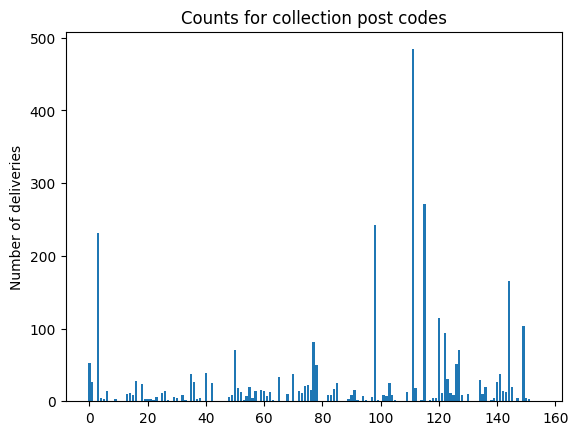

In [50]:
collect_post_code_counts = bookings.group_by("FIRST_COLLECTION_POST_CODE").agg(pl.col("FIRST_COLLECTION_POST_CODE").count().alias("count"))

fig, ax = plt.subplots(1, 1)

ax.set_title("Counts for collection post codes")
#ax.bar(np.ravel(collect_post_code_counts.select("FIRST_COLLECTION_POST_CODE").to_numpy()), 
ax.bar(np.arange(len(collect_post_code_counts)), 
       np.ravel(collect_post_code_counts.select("count").to_numpy()))
ax.set_ylabel("Number of deliveries")

plt.show()

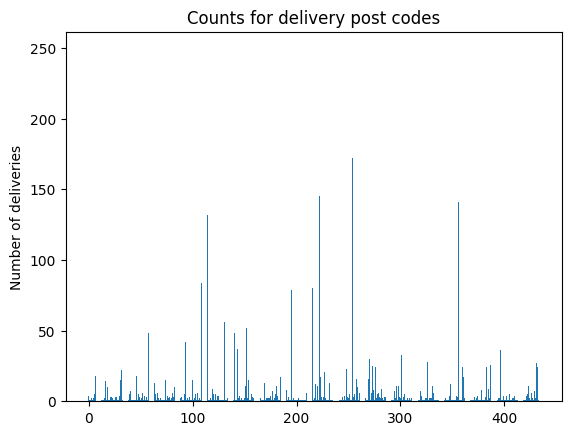

In [51]:
collect_post_code_counts = bookings.group_by("LAST_DELIVERY_POST_CODE").agg(pl.col("LAST_DELIVERY_POST_CODE").count().alias("count"))

fig, ax = plt.subplots(1, 1)

ax.set_title("Counts for delivery post codes")
#ax.bar(np.ravel(collect_post_code_counts.select("FIRST_COLLECTION_POST_CODE").to_numpy()), 
ax.bar(np.arange(len(collect_post_code_counts)), 
       np.ravel(collect_post_code_counts.select("count").to_numpy()))
ax.set_ylabel("Number of deliveries")

plt.show()

In [52]:
bookings.with_columns(pl.col("FIRST_COLLECTION_POST_CODE").str.split(' ').list.get(0).alias("collection_post_code_sector"))

PROJECT_ID,SHIPMENT_NUMBER,CARRIER_DISPLAY_ID,VEHICLE_SIZE,VEHICLE_BUILD_UP,FIRST_COLLECTION_POST_CODE,LAST_DELIVERY_POST_CODE,FIRST_COLLECTION_LATITUDE,FIRST_COLLECTION_LONGITUDE,LAST_DELIVERY_LATITUDE,LAST_DELIVERY_LONGITUDE,FIRST_COLLECTION_SCHEDULE_EARLIEST,FIRST_COLLECTION_SCHEDULE_LATEST,LAST_DELIVERY_SCHEDULE_EARLIEST,LAST_DELIVERY_SCHEDULE_LATEST,collection_post_code_sector,delivery_post_code_sector,available_time_early_late,available_time_late_late,crow_distance
str,str,str,str,str,str,str,f64,f64,f64,f64,"datetime[μs, UTC]","datetime[μs, UTC]","datetime[μs, UTC]","datetime[μs, UTC]",str,str,i64,i64,f64
"""5456fcfa-5b0c-428e-b322-240d50…","""SEZHUK-231005-250448""","""CAUK000096""","""Tractor Unit""","""Curtain-Side 13.6M Trailer""","""PE29 2XR""","""EH48 2FB""",52.315672,-0.157664,55.877803,-3.648558,2023-10-06 09:45:00 UTC,2023-10-06 10:00:00 UTC,2023-10-09 09:55:00 UTC,2023-10-09 10:25:00 UTC,"""PE29""","""EH48""",261600,260700,456.706259
"""eb7a9df0-4875-43d8-9060-c79c35…","""SEZHUK-231217-275004""","""CAUK000660""","""Tractor Unit""","""Box 44ft""","""BD5 8LZ""","""RG19 4BQ""",53.764125,-1.740145,51.398851,-1.231993,2023-12-19 14:20:00 UTC,2023-12-19 16:00:00 UTC,2023-12-20 06:00:00 UTC,2023-12-20 08:56:00 UTC,"""BD5""","""RG19""",66960,60960,265.236064
"""eb7a9df0-4875-43d8-9060-c79c35…","""SEZHUK-231210-272018""","""CAUK000435""","""Tractor Unit""","""Box 44ft""","""BD5 8LZ""","""EN3 7QP""",53.767302,-1.74656,51.6607,-0.022247,2023-12-14 01:20:00 UTC,2023-12-14 03:00:00 UTC,2023-12-14 07:03:00 UTC,2023-12-14 10:43:00 UTC,"""BD5""","""EN3""",33780,27780,261.440649
"""40415fe3-e446-4d1e-b141-3698b0…","""SEZHUK-231211-272127""","""CAUK000096""","""Tractor Unit""","""Curtain-Side 13.6M Trailer""","""HP22 5BL""","""NG31 7UH""",51.779657,-0.772897,52.888113,-0.634948,2023-12-13 09:00:00 UTC,2023-12-13 09:30:00 UTC,2023-12-13 15:30:00 UTC,2023-12-13 16:00:00 UTC,"""HP22""","""NG31""",25200,23400,123.610505
"""39a4e234-5d35-4d94-8e8a-b8bf6f…","""SEZHUK-231025-256168""","""CAUK000155""","""Tractor Unit""","""Curtain Side""","""CV23 8BQ""","""G75 0ZZ""",52.334853,-1.18045,55.735089,-4.168719,2023-11-07 14:00:00 UTC,2023-11-07 15:00:00 UTC,2023-11-07 23:00:00 UTC,2023-11-07 23:59:00 UTC,"""CV23""","""G75""",35940,32340,425.385092
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""433732b1-4db6-4969-985d-710c00…","""SEZHUK-231122-265206""","""CAUK000912""","""3.5T Van""","""Box""","""BD5 8LZ""","""LE3 8DX""",53.766832,-1.740516,52.641456,-1.216005,2023-12-02 00:30:00 UTC,2023-12-02 01:00:00 UTC,2023-12-03 02:30:00 UTC,2023-12-03 03:00:00 UTC,"""BD5""","""LE3""",95400,93600,129.919725
"""eb7a9df0-4875-43d8-9060-c79c35…","""SEZHUK-231014-253126""","""CAUK000435""","""Tractor Unit""","""Box 44ft""","""AL10 8XF""","""DE74 2HL""",51.74104,-0.218368,52.849282,-1.354253,2023-10-15 12:00:00 UTC,2023-10-15 13:55:01 UTC,2023-10-15 16:18:00 UTC,2023-10-15 17:03:01 UTC,"""AL10""","""DE74""",18181,11280,145.436348
"""433732b1-4db6-4969-985d-710c00…","""SEZHUK-231206-270513""","""CAUK000912""","""3.5T Van""","""Box""","""S35 2PW""","""LE3 8DX""",53.476537,-1.471065,52.641456,-1.216005,2023-12-16 00:30:00 UTC,2023-12-16 01:00:00 UTC,2023-12-16 03:00:00 UTC,2023-12-16 03:30:00 UTC,"""S35""","""LE3""",10800,9000,94.408041


# Logistic regression

See what we can do with something very simple

In [216]:
DAY_SECONDS = 24*60*60
DRIVE_SECONDS = 8*60*60

drive_times = bookings.select([pl.col("SHIPMENT_NUMBER"),
                               ((pl.col("available_time_late_late") // (DAY_SECONDS))*DRIVE_SECONDS 
                                   + pl.when(pl.col("available_time_late_late")%(DAY_SECONDS) < DRIVE_SECONDS)
                                       .then(pl.col("available_time_late_late")%(DAY_SECONDS))
                                       .otherwise(DRIVE_SECONDS)).alias("available_drive_time_late_late"),
                               ((pl.col("available_time_early_late") // (DAY_SECONDS))*DRIVE_SECONDS 
                                   + pl.when(pl.col("available_time_early_late")%(DAY_SECONDS) < DRIVE_SECONDS)
                                       .then(pl.col("available_time_early_late")%(DAY_SECONDS))
                                       .otherwise(DRIVE_SECONDS)).alias("available_drive_time_early_late"),
                               pl.col("crow_distance")])

drive_times = drive_times.with_columns([(60*60*pl.col("crow_distance") / (pl.col("available_drive_time_early_late")+1)).alias("crow_speed_early_late"),
                                        (60*60*pl.col("crow_distance") / (pl.col("available_drive_time_late_late")+1)).alias("crow_speed_late_late")])

drive_times_with_y = arrivals.select("SHIPMENT_NUMBER", "is_late").join(drive_times, on="SHIPMENT_NUMBER")
X = drive_times_with_y.select(pl.exclude(["SHIPMENT_NUMBER", "is_late"] + date_time_columns))
y = np.ravel(drive_times_with_y.select("is_late").to_numpy())

In [217]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [218]:
lr = LogisticRegression()
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
lr.fit(X_train, y_train)
lr.predict(X_test).mean()

0.0

In [219]:
lr.coef_

array([[ 0.04677324, -0.02127275,  0.17011104,  0.27813346, -0.05336425]])

In [221]:
X

available_drive_time_late_late,available_drive_time_early_late,crow_distance,crow_speed_early_late,crow_speed_late_late
i64,i64,f64,f64,f64
27780,28800,261.440649,32.678946,33.878778
23400,25200,123.610505,17.657943,19.016188
28800,28800,425.385092,53.17129,53.17129
25140,28740,429.191572,53.759078,61.456969
6300,8100,29.98788,13.326302,17.133212
…,…,…,…,…
13500,17100,157.154701,33.083266,41.904816
36000,37800,129.919725,12.37298,12.991612
11280,18181,145.436348,28.796109,46.411741
